In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [25]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


#### Train : data type info 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9366 entries, 0 to 9365
Data columns (total 18 columns):
portfolio_id      9366 non-null object
desk_id           5701 non-null object
office_id         9366 non-null object
pf_category       9366 non-null object
start_date        9366 non-null int64
sold              9364 non-null float64
country_code      9366 non-null object
euribor_rate      9366 non-null float64
currency          9366 non-null object
libor_rate        8892 non-null float64
bought            9364 non-null float64
creation_date     9366 non-null int64
indicator_code    3667 non-null object
sell_date         9366 non-null int64
type              9366 non-null object
hedge_value       3665 non-null object
status            6282 non-null object
return            9366 non-null float64
dtypes: float64(5), int64(3), object(10)
memory usage: 1.3+ MB


#### Train : statastical information of numeric columns

In [39]:
train.describe()

,start_date,sold,euribor_rate,libor_rate,bought,creation_date,sell_date,return
count,9.366000e+03,9.364000e+03,9366.000000,8892.000000,9.364000e+03,9.366000e+03,9.366000e+03,9366.000000
mean,2.011706e+07,1.019748e+08,0.009383,0.998066,1.018914e+08,2.011706e+07,2.011770e+07,0.014100
std,3.052996e+04,1.928097e+08,0.013298,1.457977,1.927472e+08,3.052372e+04,3.060900e+04,0.020549
min,2.004041e+07,1.100000e+00,-0.003740,-0.667095,1.099698e+00,2.004072e+07,2.004071e+07,-0.009600
25%,2.010020e+07,2.763200e+07,0.000980,0.244490,2.761285e+07,2.010020e+07,2.010023e+07,0.003000
50%,2.011120e+07,5.517050e+07,0.004390,0.531983,5.512056e+07,2.011120e+07,2.011121e+07,0.005400
75%,2.014071e+07,1.144632e+08,0.013510,1.109959,1.144459e+08,2.014071e+07,2.014083e+07,0.014520
max,2.017103e+07,1.320000e+10,0.050880,6.379137,1.320000e+10,2.017103e+07,2.017103e+07,0.778441


#### Train : size  rows = 9366  cols = 18

In [33]:
print(" Train data : number of rows = {0} and number of columns = {1}".format(train.shape[0], train.shape[1]))

 Train data : number of rows = 9366 and number of columns = 18


#### Train : number of null values for each column

In [5]:
train.isnull().sum(axis= 0)

portfolio_id         0
desk_id           3665
office_id            0
pf_category          0
start_date           0
sold                 2
country_code         0
euribor_rate         0
currency             0
libor_rate         474
bought               2
creation_date        0
indicator_code    5699
sell_date            0
type                 0
hedge_value       5701
status            3084
return               0
dtype: int64

#### Train : number of unique values for each column

In [37]:
for column in train.columns:
    print("{0} : {1}".format(column, train[column].value_counts().count()))

portfolio_id : 9366
desk_id : 3992
office_id : 2
pf_category : 5
start_date : 2601
sold : 4415
country_code : 5
euribor_rate : 149
currency : 5
libor_rate : 468
bought : 8639
creation_date : 2612
indicator_code : 1
sell_date : 2632
type : 8
hedge_value : 2
status : 1
return : 1129


In [40]:
test.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status
0,PF00001001,DSK00001001,OFF00001001,A,20040720,171831000.0,T,0.02074,USD,2.332216,1.715337e+08,20040720,NaN,20040812,A,NaN,NaN
1,PF00001004,DSK00001003,OFF00001002,B,20040723,56485000.0,T,0.02074,USD,2.332216,5.638038e+07,20040723,NaN,20040719,B,NaN,NaN
2,PF00001009,DSK00001007,OFF00001001,A,20040607,41734000.0,T,0.02074,USD,2.332216,4.166179e+07,20040726,NaN,20040709,A,NaN,NaN
3,PF00001013,DSK00001011,OFF00001001,A,20040716,82951000.0,T,0.02074,USD,2.332216,8.250936e+07,20040726,NaN,20041019,A,NaN,NaN
4,PF00001014,DSK00001012,OFF00001001,A,20040713,73293000.0,T,0.02074,USD,2.332216,7.317055e+07,20040726,NaN,20040813,A,NaN,NaN


#### Test : statastical information of numerical columns

In [41]:
test.describe()

,start_date,sold,euribor_rate,libor_rate,bought,creation_date,sell_date
count,4.801000e+03,4.801000e+03,4801.000000,4536.000000,4.801000e+03,4.801000e+03,4.801000e+03
mean,2.011849e+07,1.024942e+08,0.008717,0.930464,1.024165e+08,2.011849e+07,2.011911e+07
std,2.992170e+04,1.356065e+08,0.012747,1.387474,1.355206e+08,2.991692e+04,3.005556e+04
min,2.004061e+07,1.100000e+00,-0.003740,-0.667095,1.099989e+00,2.004072e+07,2.004071e+07
25%,2.010052e+07,2.891900e+07,0.000970,0.240305,2.891866e+07,2.010053e+07,2.010061e+07
50%,2.012010e+07,5.725500e+07,0.004250,0.531493,5.725304e+07,2.012010e+07,2.012011e+07
75%,2.014083e+07,1.210000e+08,0.013320,1.065318,1.209652e+08,2.014083e+07,2.014100e+07
max,2.017103e+07,1.560212e+09,0.050880,6.434407,1.560168e+09,2.017103e+07,2.017103e+07


#### Test : size  rows = 4801  cols = 17

In [42]:
print("Test data : number of rows = {0} and number of columns = {1}".format(test.shape[0], test.shape[1]))

Test data : number of rows = 4801 and number of columns = 17


#### Test : number of null values for each column

In [43]:
test.isnull().sum(axis = 0)

portfolio_id         0
desk_id           1948
office_id            0
pf_category          0
start_date           0
sold                 0
country_code         0
euribor_rate         0
currency             0
libor_rate         265
bought               0
creation_date        0
indicator_code    2851
sell_date            0
type                 0
hedge_value       2851
status            1457
dtype: int64

#### Test : number of unique values for each column

In [44]:
for column in test.columns:
    print("{0} : {1}".format(column, test[column].value_counts().count()))

portfolio_id : 4801
desk_id : 2197
office_id : 2
pf_category : 4
start_date : 2079
sold : 2560
country_code : 5
euribor_rate : 149
currency : 5
libor_rate : 421
bought : 4569
creation_date : 2082
indicator_code : 1
sell_date : 2090
type : 7
hedge_value : 2
status : 1


In [62]:
# encode categorical fields
obj_cols = [x for x in train.columns if train[x].dtype == 'object']
obj_cols = [x for x in obj_cols if x not in ['portfolio_id','desk_id','office_id']]
encoder = LabelEncoder()
for x in obj_cols:
    mask_train = ~train[x].isnull()
    mask_test = ~test[x].isnull()
    encoder.fit(train[x][mask_train])
    train[x][mask_train] = encoder.transform(train[x][mask_train])
    test[x][mask_test] = encoder.transform(test[x][mask_test])
    print(x)

['pf_category', 'country_code', 'currency', 'indicator_code', 'type', 'hedge_value', 'status']
pf_category


C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


country_code
currency
indicator_code
type
hedge_value
status


In [73]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,1,20040720,110000000.0,2,0.02074,4,2.332216,1.098097e+08,20040720,NaN,20040812,1,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,0,20040709,176671000.0,1,0.02074,2,5.269617,1.760084e+08,20040723,NaN,20040812,2,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,0,20040723,56474000.0,2,0.02074,4,2.332216,5.637953e+07,20040723,NaN,20040817,0,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,0,20040609,164813000.0,2,0.02074,4,2.332216,1.645088e+08,20040723,NaN,20040713,0,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,1,20040609,140800000.0,2,0.02074,4,2.332216,1.405402e+08,20040723,NaN,20040713,1,NaN,NaN,0.02496


In [74]:
test.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status
0,PF00001001,DSK00001001,OFF00001001,0,20040720,171831000.0,2,0.02074,4,2.332216,1.715337e+08,20040720,NaN,20040812,0,NaN,NaN
1,PF00001004,DSK00001003,OFF00001002,1,20040723,56485000.0,2,0.02074,4,2.332216,5.638038e+07,20040723,NaN,20040719,1,NaN,NaN
2,PF00001009,DSK00001007,OFF00001001,0,20040607,41734000.0,2,0.02074,4,2.332216,4.166179e+07,20040726,NaN,20040709,0,NaN,NaN
3,PF00001013,DSK00001011,OFF00001001,0,20040716,82951000.0,2,0.02074,4,2.332216,8.250936e+07,20040726,NaN,20041019,0,NaN,NaN
4,PF00001014,DSK00001012,OFF00001001,0,20040713,73293000.0,2,0.02074,4,2.332216,7.317055e+07,20040726,NaN,20040813,0,NaN,NaN


In [66]:
feature_names = [x for x in train.columns if x not in ['portfolio_id', 'desk_id', 'office_id', 'return']]

In [78]:
train[feature_names] = train[feature_names].apply(pd.to_numeric, errors='ignore')
test[feature_names] = test[feature_names].apply(pd.to_numeric, errors='ignore')

In [69]:
def modelfit(model, train_data, train_label, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        params = {
            'objective' : xgb_param['objective'],
            'base_score' : xgb_param['base_score'],
            'colsample_bylevel' : xgb_param['colsample_bylevel'],
            'colsample_bytree' : xgb_param['colsample_bytree'],
            'gamma' : xgb_param['gamma'],
            'eta' : xgb_param['learning_rate'],
            'max_delta_step' : xgb_param['max_delta_step'],
            'max_depth' : xgb_param['max_depth'],
            'min_child_weight' : xgb_param['min_child_weight'],
            'alpha' : xgb_param['reg_alpha'],
            'lambda': xgb_param['reg_lambda'],
            'scale_pos_weight' : xgb_param['scale_pos_weight'],
            'subsample' : xgb_param['subsample'],     
        }
           
        dtrain = xgb.DMatrix(data=train_data[predictors], label=train_label)
        cvresult = xgb.cv(params , dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        # print(cvresult)
        print("########### n_estimators = %f" % cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(train_data[predictors], train_label,eval_metric='rmse')
        
    # Predict training set:
    train_predictions = model.predict(train_data[predictors])
    #train_predprob = model.predict_proba(train_data[predictors])[:,1]
    
    # Predict X_valid set:
    #valid_predictions = model.predict(X_valid[predictors])
    #valid_predprob = model.predict_proba(X_valid[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("r2 score (Train): %.5g" % r2_score(train_label, train_predictions))
    print("Accuracy score (Train): %.5g" % accuracy_score(train_label, train_predictions))
    # print("AUC Score (Train): %f" % roc_auc_score(train_label, train_predprob))
    #print("r2 score (Validation): %.5g" % r2_score(y_valid, valid_predictions))
    # print("AUC Score (Validation): %f" % roc_auc_score(y_valid, valid_predprob))
    
    feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return model

In [70]:
clf1 = xgb.XGBClassifier(objective ='reg:linear',learning_rate=0.1, max_depth=4, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, gamma=0, min_child_weight= 1, reg_alpha=0)

########### n_estimators = 56.000000

Model Report
r2 score (Train): 0.79776


<IPython.core.display.Javascript object>


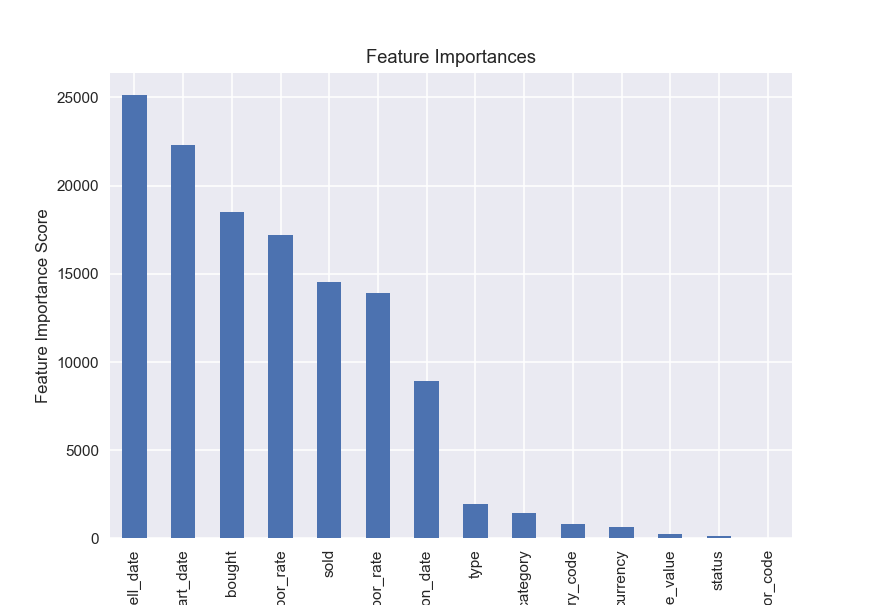

In [79]:
clf1 = modelfit(clf1, train, train['return'], feature_names)

In [80]:
pred1 = clf1.predict(test[feature_names])

In [81]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['return'] = pred1
sub.to_csv('sub_xgb.csv', index=False)